<a href="https://colab.research.google.com/github/FlaviaLopes/dio-challenges-coding-the-future-with-baires-dev/blob/main/projeto_3/M%C3%A9tricas_de_valida%C3%A7%C3%A3o_para_modelos_de_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.metrics import multilabel_confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

## Loading the data

_Interpretando as predições da rede ResNet50_

- O modelo ResNet50 treinado com transfer learning no dataset CelebA, no projeto 1, gerou uma matriz de predições para o conjunto de teste.
- O y e ŷ são carregados neste notebook, e a partir deles a matriz de confusão multilabel é criada, e várias métricas são analisadas por classe.

In [40]:
base_dir = "base_dir"
preds_path = os.path.join(base_dir, "projeto_1/output/ResNet50_CelebA_predictions.csv")
labels_path = "/content/drive/MyDrive/DIO Baires Dev/datasets/celeb_a/attr_celeb_a_sample.csv"

labels = pd.read_csv(labels_path)
classes = labels.columns[1:]

preds = pd.read_csv(preds_path)
y_true = preds.y_true.map(lambda x: [np.uint(float(it)) for it in x.replace('[', '').replace(']', '').split()])
y_pred = preds.y_pred.map(lambda x: [np.uint(float(it)) for it in x.replace('[', '').replace(']', '').split()])

y_true = np.array(y_true.tolist())
y_pred = np.array(y_pred.tolist())

## Helpers

In [87]:
def color_cells(val):
    if type(val) == int:
        color = 'white'
    elif val >= 0.8:
        color = 'lightgreen'
    elif val >= 0.5:
        color = 'lightblue'
    else:
        color = 'tomato'
    return 'background-color: %s' % color

## Calculando as métricas

As métricas podem ser facilmente calculadas de maneira algorítmica, ou seja, sem uso de bibliotecas especializadas.

A seguir é demonstrado como:
- capturar cada métrica a partir da matriz confusão multilabel.
- calcular as métricas usando módulos especialistas

In [76]:
# criação da matriz confusão multilabel
mcm = multilabel_confusion_matrix(y_true, y_pred)

# lambda functions para cálculo direto através da matriz confusão.
recall = lambda x: x['TP'] / (x['TP'] + x['FN'])
specificity = lambda x: x['TN'] / (x['TN'] + x['FP'])
precision = lambda x: x['TP'] / (x['TP'] + x['FP'])
accuracy = lambda x: (x['TP'] + x['TN']) / (x['FN'] + x['FP'] + x['TN'] + x['TP'])
f1_score = lambda x: 2 * (x['precision'] * x['recall']) / (x['precision'] + x['recall'])

# criação da tabela de métricas
data = pd.DataFrame(
    data = {
        'TN': mcm[:, 0, 0],
        'FP': mcm[:, 0, 1],
        'FN': mcm[:, 1, 0],
        'TP': mcm[:, 1, 1]
    },
    index=classes
)

# cálculo direto a partir dos valores da matriz confusão carregados na tabela
data['recall'] = data.apply(recall, axis=1)
data['specificity'] = data.apply(specificity, axis=1)
data['precision'] = data.apply(precision, axis=1)
data['accuracy'] = data.apply(accuracy, axis=1)
data['f1_score'] = data.apply(f1_score, axis=1)
data['support'] = [y_true[:, c].sum() for c in range(len(classes))]
data['support_norm'] = data.support.map(lambda x: x / data.support.max())

# o runtime warning ""
data = data.fillna(0)

# cálculo das métricas a partir das bibliotecas sklearn e imblearn
from imblearn.metrics import specificity_score

data['recall_skl'] = [metrics.recall_score(y_true[:, c], y_pred[:, c], average='binary', zero_division=0.0) for c in range(len(classes))]
data['specificity_imbl'] = [specificity_score(y_true[:, c], y_pred[:, c], average='binary') for c in range(len(classes))]
data['precision_skl'] = [metrics.precision_score(y_true[:, c], y_pred[:, c], average='binary', zero_division=0.0) for c in range(len(classes))]
data['accuracy_skl'] = [metrics.accuracy_score(y_true[:, c], y_pred[:, c]) for c in range(len(classes))]
data['f1_score_skl'] = [metrics.f1_score(y_true[:, c], y_pred[:, c], average='binary', zero_division=0.0) for c in range(len(classes))]

# truncando os dados em ponto flutuante em 4 casas decimais
data.loc[:, data.select_dtypes(float).columns] = data.loc[:, data.select_dtypes(float).columns].apply(lambda x: round(x, 4), axis=1)

<ipython-input-76-2f1763351d86>:7: RuntimeWarning: invalid value encountered in scalar divide
  precision = lambda x: x['TP'] / (x['TP'] + x['FP'])


Agora vamos checar se as métricas batem. E temos que o cálculo direto está idêntico ao realizado pelas bibliotecas especialistas.

O cálculo direto utilizou dados de TP, TN, FP, FN da matriz confusão. E as bibliotecas especialistas utilizou os dados de y_pred e y_true, uma classe por vez, para analisar o desempenho de cada uma separadamente.

In [92]:
print(
    (data.recall_skl == data.recall).mean(),
    (data.specificity_imbl == data.specificity).mean(),
    (data.precision_skl == data.precision).mean(),
    (data.accuracy_skl == data.accuracy).mean(),
    (data.f1_score_skl == data.f1_score).mean()
)

1.0 1.0 1.0 1.0 1.0


Neste caso específico, o falso positivo é pior que o falso negativo. Classificar uma mulher como Male, ou uma pessoa de cabelo preto, como cabelo loiro, é pior do que não identificar essas características.

De acordo com o número de FP, a seguir temos as classes mais problemáticas.

In [91]:
data.loc[:, :'support_norm'].sort_values('FP', ascending=False).head(10).style.applymap(color_cells)

<ipython-input-91-c6e7e3ad2cd5>:2: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  data.loc[:, :'support_norm'].sort_values('FP', ascending=False).head(10).style.applymap(color_cells)


,TN,FP,FN,TP,recall,specificity,precision,accuracy,f1_score,support,support_norm
Big_Nose,252,124,72,142,0.663600,0.670200,0.533800,0.667800,0.591700,214,0.489700
Mouth_Slightly_Open,164,115,93,218,0.701000,0.587800,0.654700,0.647500,0.677000,311,0.711700
Male,179,111,14,286,0.953300,0.617200,0.720400,0.788100,0.820700,300,0.686500
No_Beard,77,76,91,346,0.791800,0.503300,0.819900,0.716900,0.805600,437,1.000000
Young,122,70,103,295,0.741200,0.635400,0.808200,0.706800,0.773300,398,0.910800
Bags_Under_Eyes,356,65,119,50,0.295900,0.845600,0.434800,0.688100,0.352100,169,0.386700
Smiling,208,63,117,202,0.633200,0.767500,0.762300,0.694900,0.691800,319,0.730000
High_Cheekbones,242,59,117,172,0.595200,0.804000,0.744600,0.701700,0.661500,289,0.661300
Wavy_Hair,381,34,128,47,0.268600,0.918100,0.580200,0.725400,0.367200,175,0.400500
Wearing_Necktie,486,30,46,28,0.378400,0.941900,0.482800,0.871200,0.424200,74,0.169300


## Otimização do modelo

__Por quais atributos começar?__
---

Podemos usar como referência a pesquisa que publicou este dataset, que já fez uma análise exploratória e trouxe insights importantes sobre os atributos da base: [Deep Learning Face Attributes in the Wild](https://arxiv.org/pdf/1411.7766).

Os autores clusterizaram os pesos da rede para compreender melhor como os atributos estavam se relacionando. E descobriram grupos com relação de co-ocorrrência forte, e outros cujos atributos tinham em comum as cores ou texturas.

>"As shown in Fig.11, Group #1, Group #2 and Group #4 demonstrate co-occurrence relationship between attributes, e.g. ‘Attractive’ and ‘Heavy Makeup’ have high
correlation. Attributes in Group #3 share similar color descriptors, while attributes in Group #6 correspond to certain texture and appearance traits."

De acordo com essas informações e análise exploratória realizada no projeto 1, parece mais razoável começar otimizando o modelo a partir dos atributos com forte co-ocorrência. Alguns destes, inclusive, são as classes com maior suporte. Uma melhoria nas métricas dessas classes pode levar o modelo a performar melhor.

Nas iterações seguintes, a questão dos atributos com cores e texturas semelhantes, e que não performaram bem após a primeira otimização pode ser reavaliada.

__Qual o foco: diminuir FP ou FN?__
---
Neste cenário, o falso positivo é pior que o falso negativo. Melhorias em todas as métricas importam, mas principalmente em precisão e especificidade, pois quanto menos FP, mais próximo de 1 serão essas métricas.

__Plano para a próxima iteração__
---
- Focar nos grupos 1, 2 e 4, com forte co-ocorrência. Preferencialmente os atributos de maior suporte.
- Para cada atributo, ranqueado pelo suporte:
  - Avaliar a matriz de confusão da classe, e se houver FP significante:
  - Inspecionar algumas imagens com FP
  - Para as imagens com FP nesta classe, verificar quais outras classes ocorrem.
    - algumas perguntas: os atributos associados a esta classe diferem dos que ocorrem no grupo de FP? pode trazer uma direção mais assertiva para o data augmentation, focando nos exemplos que a rede teve dificuldade de aprender.

__Grupos semânticos__
---
_atributos dos grupos 1, 2 e 4, ordenados por suporte:_

- atributos considerados:
  - acima de 50% de suporte, em relação a classe maioritária
  - atributos dos grupos 1, 2 e 4
  - atributos selecionados para primeira otimização: `No_Beard, Young, Smiling, Mouth_Slightly_Open, High_Cheekbones, Wearing_Lipstick`
  - em seguida os demais dos grupos 1, 2 e 4 podem ser avaliados.


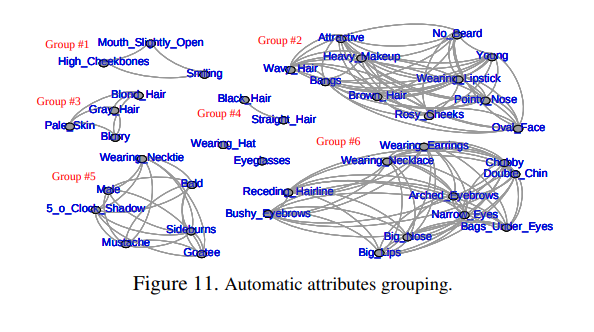

__Próximo passo...__

é compreender os falsos positivos:
- quais classes ocorrem simultaneamente com as imagens classificadas erroneamente como `No_Beard`? Alguma característica pode estar confundindo o modelo? Esta característica ruidosa tem baixo suporte?

- estas respostas podem indicar a abordagem: oversampling ou undersampling focando em qual grupo de imagens?

__Abaixo temos as primeiras classes a serem investigadas com maior potencial de impacto no desempenho do modelo__

In [88]:
attrs = ['No_Beard', 'Young', 'Smiling', 'Mouth_Slightly_Open', 'High_Cheekbones', 'Wearing_Lipstick']
data.loc[attrs, :'support_norm'].sort_values('support', ascending=False).style.applymap(color_cells)

<ipython-input-88-c819a60f3703>:2: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  data.loc[attrs, :'support_norm'].sort_values('support', ascending=False).style.applymap(color_cells)


,TN,FP,FN,TP,recall,specificity,precision,accuracy,f1_score,support,support_norm
No_Beard,77,76,91,346,0.791800,0.503300,0.819900,0.716900,0.805600,437,1.000000
Young,122,70,103,295,0.741200,0.635400,0.808200,0.706800,0.773300,398,0.910800
Smiling,208,63,117,202,0.633200,0.767500,0.762300,0.694900,0.691800,319,0.730000
Mouth_Slightly_Open,164,115,93,218,0.701000,0.587800,0.654700,0.647500,0.677000,311,0.711700
High_Cheekbones,242,59,117,172,0.595200,0.804000,0.744600,0.701700,0.661500,289,0.661300
Wearing_Lipstick,326,23,100,141,0.585100,0.934100,0.859800,0.791500,0.696300,241,0.551500
